Error finding minimum volatility portfolio: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.
Error finding maximum Sharpe ratio portfolio: The objective function was changed after the initial optimization. Please create a new instance instead.


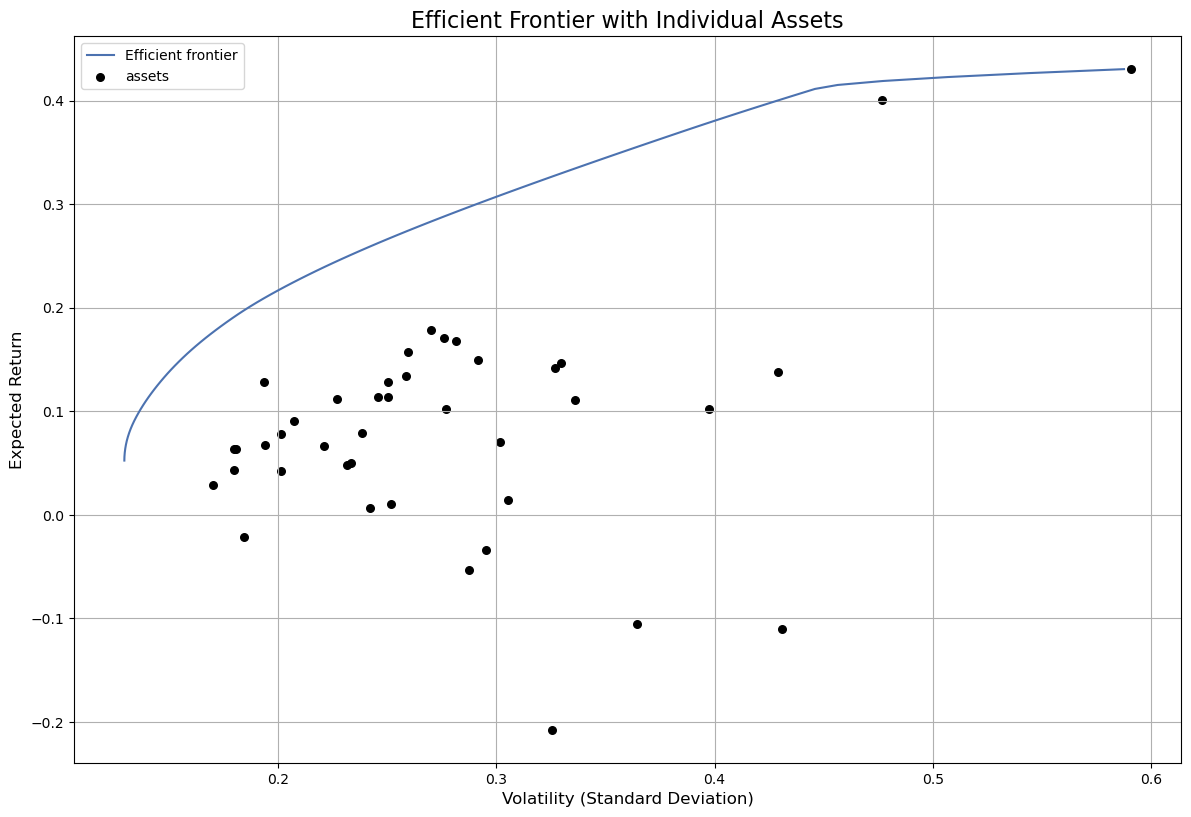

Error finding maximum Sharpe ratio portfolio: The objective function was changed after the initial optimization. Please create a new instance instead.
Error finding minimum volatility portfolio: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.


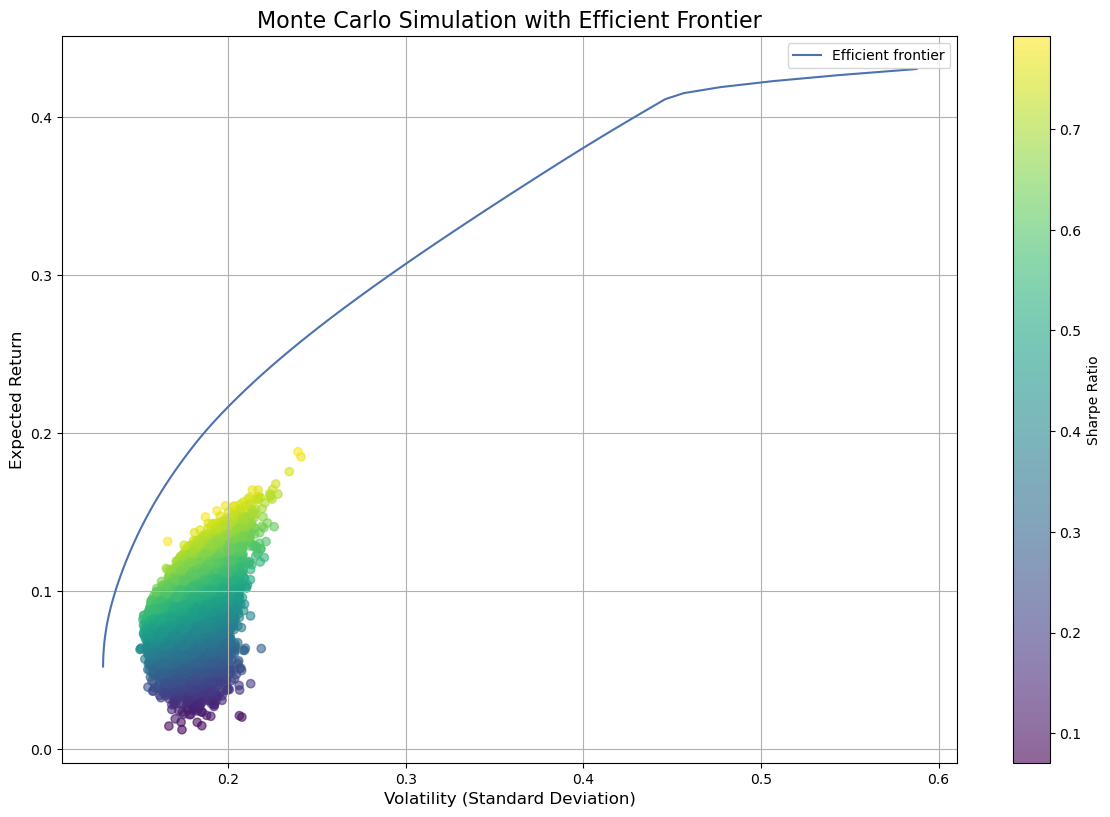

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting

# Load your data
base_path = '../Fetch_data/data'
us_30_folder = os.path.join(base_path, 'US-30')
extra10_folder = os.path.join(base_path, 'Extra10')
dow_jones_file = os.path.join(base_path, 'indices', 'DOW_JONES_2020_2024.csv')

def load_price_data(folder_path):
    price_data = pd.DataFrame()
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
            df = df[['Adj Close']]
            df.columns = [file_name.replace('.csv', '')]
            price_data = pd.concat([price_data, df], axis=1)
    return price_data

# Load and prepare data
us_30_data = load_price_data(us_30_folder)
extra10_data = load_price_data(extra10_folder)
dow_jones_data = pd.read_csv(dow_jones_file, parse_dates=['Date'], index_col='Date')
dow_jones_data = dow_jones_data[['Adj Close']].rename(columns={'Adj Close': 'DOW_JONES_2020_2024'})

price_data = pd.concat([us_30_data, extra10_data, dow_jones_data], axis=1).fillna(method='ffill').fillna(method='bfill')

# Check for valid data alignment
expected_returns = expected_returns.mean_historical_return(price_data)
covariance_matrix = risk_models.CovarianceShrinkage(price_data).ledoit_wolf()

# Ensure alignment and drop NaN
expected_returns = expected_returns.dropna()
covariance_matrix = covariance_matrix.loc[expected_returns.index, expected_returns.index]

# Plot Efficient Frontier with Individual Assets
def plot_efficient_frontier_with_assets():
    ef = EfficientFrontier(expected_returns, covariance_matrix)
    fig, ax = plt.subplots(figsize=(12, 8))
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

    # Highlight the minimum volatility portfolio
    try:
        min_vol_port = ef.min_volatility()
        min_vol_point = ef.portfolio_performance()
        ax.scatter(min_vol_point[1], min_vol_point[0], color='red', s=100, label="Minimum Volatility Portfolio")
    except Exception as e:
        print(f"Error finding minimum volatility portfolio: {e}")

    # Highlight the maximum Sharpe ratio portfolio
    try:
        max_sharpe_port = ef.max_sharpe()
        max_sharpe_point = ef.portfolio_performance()
        ax.scatter(max_sharpe_point[1], max_sharpe_point[0], color='green', s=100, label="Maximum Sharpe Ratio Portfolio")
    except Exception as e:
        print(f"Error finding maximum Sharpe ratio portfolio: {e}")

    ax.set_title("Efficient Frontier with Individual Assets", fontsize=16)
    plt.xlabel("Volatility (Standard Deviation)", fontsize=12)
    plt.ylabel("Expected Return", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot Efficient Frontier with Monte Carlo Simulations
def plot_monte_carlo():
    n_samples = 50000  # Increased samples for smoother distribution
    random_weights = np.random.dirichlet(np.ones(len(expected_returns)), n_samples)
    rets = np.dot(random_weights, expected_returns.values)
    vols = np.sqrt(np.diag(random_weights @ covariance_matrix.values @ random_weights.T))
    sharpes = rets / vols

    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(vols, rets, c=sharpes, cmap='viridis', marker='o', alpha=0.6)

    # Plot the efficient frontier
    ef = EfficientFrontier(expected_returns, covariance_matrix)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Highlight the maximum Sharpe ratio and minimum volatility points
    try:
        max_sharpe_port = ef.max_sharpe()
        max_sharpe_point = ef.portfolio_performance()
        ax.scatter(max_sharpe_point[1], max_sharpe_point[0], color='green', s=100, label="Maximum Sharpe Ratio Portfolio")
    except Exception as e:
        print(f"Error finding maximum Sharpe ratio portfolio: {e}")

    try:
        min_vol_port = ef.min_volatility()
        min_vol_point = ef.portfolio_performance()
        ax.scatter(min_vol_point[1], min_vol_point[0], color='red', s=100, label="Minimum Volatility Portfolio")
    except Exception as e:
        print(f"Error finding minimum volatility portfolio: {e}")

    # Add a color bar for Sharpe Ratio
    cbar = fig.colorbar(scatter, label='Sharpe Ratio')
    cbar.ax.tick_params(labelsize=10)

    ax.set_title("Monte Carlo Simulation with Efficient Frontier", fontsize=16)
    plt.xlabel("Volatility (Standard Deviation)", fontsize=12)
    plt.ylabel("Expected Return", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot the updated graphs
plot_efficient_frontier_with_assets()
plot_monte_carlo()
